Found 1090 label files under 'data/pineapple_defect'.


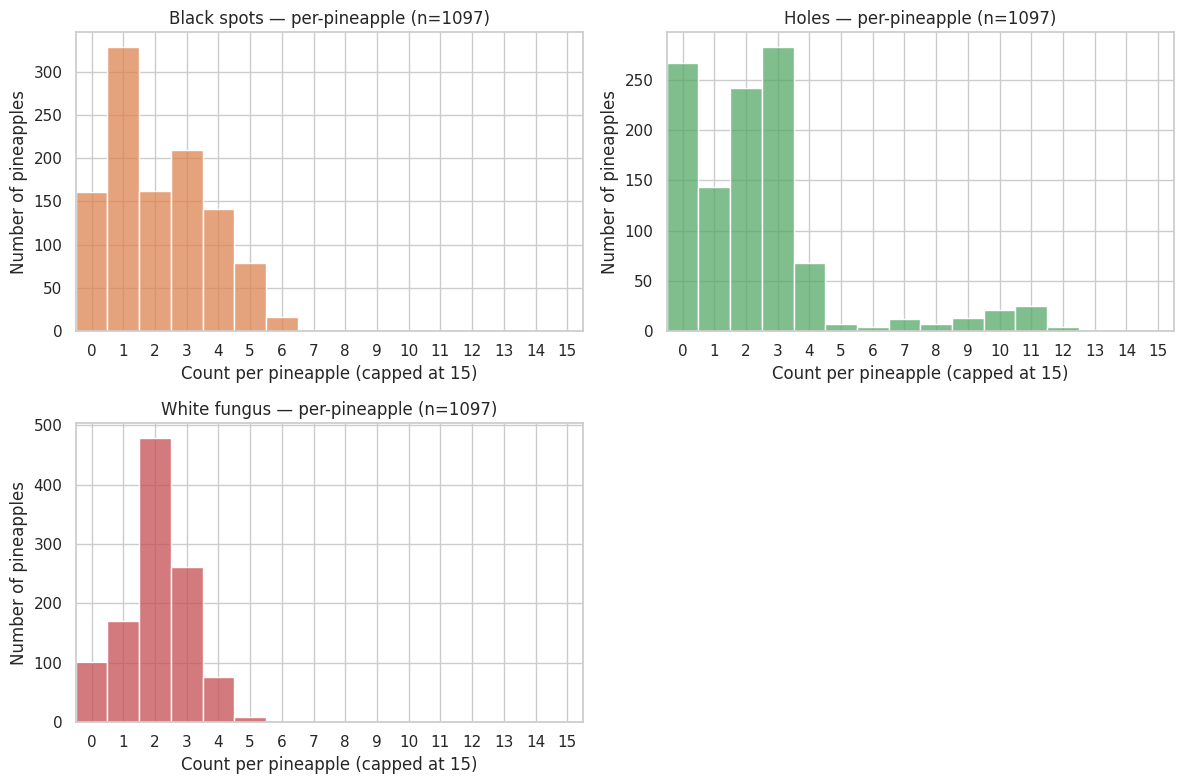


Anomaly statistics (per-pineapple)
Black spots (class 0):
  - Pineapples evaluated: 1097
  - Total Black spots: 2335
  - Mean per-pineapple: 2.129
  - Median: 2.0
  - Std dev: 1.567
  - Min: 0, Max: 6
  - Pineapples with zero Black spots: 161 (14.7%)
----------------------------------------
Holes (class 1):
  - Pineapples evaluated: 1097
  - Total Holes: 2610
  - Mean per-pineapple: 2.379
  - Median: 2.0
  - Std dev: 2.492
  - Min: 0, Max: 13
  - Pineapples with zero Holes: 267 (24.3%)
----------------------------------------
White fungus (class 2):
  - Pineapples evaluated: 1097
  - Total White fungus: 2260
  - Mean per-pineapple: 2.060
  - Median: 2.0
  - Std dev: 1.055
  - Min: 0, Max: 5
  - Pineapples with zero White fungus: 102 (9.3%)
----------------------------------------


In [ ]:
# defect distribution analysis

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Configuration
DATASET_DIR = "data/pineapple_defect"
ANOMALY_CLASSES = {0: 'Black spots', 1: 'Holes', 2: 'White fungus'}
PINEAPPLE_CLASS = 3
HIST_MAX = 15  

# Find all label files under dataset (train/valid/test)
label_files = glob.glob(os.path.join(DATASET_DIR, "**", "labels", "*.txt"), recursive=True)
print(f"Found {len(label_files)} label files under '{DATASET_DIR}'.")

# Containers: for each anomaly class we will collect counts per pineapple
counts_per_anomaly = {c: [] for c in ANOMALY_CLASSES}

# Helper to convert normalized bbox to (x1,y1,x2,y2)
def bbox_xywh_to_xyxy(xc, yc, w, h):
    x1 = xc - w / 2.0
    y1 = yc - h / 2.0
    x2 = xc + w / 2.0
    y2 = yc + h / 2.0
    return x1, y1, x2, y2

# Process each label file (one file = one image)
for lf in label_files:
    with open(lf, 'r') as f:
        lines = [l.strip() for l in f.readlines() if l.strip()]

    if not lines:
        continue

    pineapple_boxes = []  # list of (x1,y1,x2,y2)
    anomaly_boxes = []    # list of (class, x_center, y_center, w, h)

    for line in lines:
        parts = line.split()
        if len(parts) < 5:
            continue
        cls = int(float(parts[0]))
        xc, yc, w, h = map(float, parts[1:5])
        if cls == PINEAPPLE_CLASS:
            pineapple_boxes.append(bbox_xywh_to_xyxy(xc, yc, w, h))
        elif cls in ANOMALY_CLASSES:
            anomaly_boxes.append((cls, xc, yc, w, h))

    # If there are no pineapples annotated in the image, skip (can't assign anomalies to a pineapple)
    if not pineapple_boxes:
        # Option: we could still count anomalies per-image, but requirement is per-pineapple
        continue

    # For each pineapple, count anomalies whose centers fall inside pineapple bbox
    for p_box in pineapple_boxes:
        px1, py1, px2, py2 = p_box
        # initialize counts for this pineapple
        counts = {c: 0 for c in ANOMALY_CLASSES}
        for (cls, axc, ayc, aw, ah) in anomaly_boxes:
            # anomaly center in normalized coords (axc, ayc)
            if (axc >= px1) and (axc <= px2) and (ayc >= py1) and (ayc <= py2):
                counts[cls] += 1
        # append counts to respective lists
        for c in ANOMALY_CLASSES:
            counts_per_anomaly[c].append(counts[c])

# Summarize and plot
os.makedirs('runs/infer/analysis', exist_ok=True)
plt.figure(figsize=(12, 8))

for idx, (cls, name) in enumerate(ANOMALY_CLASSES.items(), start=1):
    vals = np.array(counts_per_anomaly[cls]) if len(counts_per_anomaly[cls]) > 0 else np.array([])
    # Cap values at HIST_MAX for plotting
    vals_capped = np.minimum(vals, HIST_MAX)

    plt.subplot(2, 2, idx)
    sns.histplot(vals_capped, bins=np.arange(0, HIST_MAX+2)-0.5, kde=False, discrete=True, color=f'C{idx}')
    plt.title(f"{name} — per-pineapple (n={len(vals)})")
    plt.xlabel('Count per pineapple (capped at 15)')
    plt.ylabel('Number of pineapples')
    plt.xlim(-0.5, HIST_MAX + 0.5)
    plt.xticks(range(0, HIST_MAX+1, 1))

plt.tight_layout()
# plt.savefig('runs/infer/analysis/anomalies_per_pineapple_histograms.png', dpi=150)
plt.show()

# Print statistics for each anomaly
print('\n' + '='*60)
print('Anomaly statistics (per-pineapple)')
print('='*60)
for cls, name in ANOMALY_CLASSES.items():
    vals = np.array(counts_per_anomaly[cls]) if len(counts_per_anomaly[cls]) > 0 else np.array([])
    total = int(vals.sum()) if vals.size else 0
    n_items = vals.size
    mean = float(vals.mean()) if vals.size else 0.0
    median = float(np.median(vals)) if vals.size else 0.0
    std = float(vals.std(ddof=0)) if vals.size else 0.0
    minimum = int(vals.min()) if vals.size else 0
    maximum = int(vals.max()) if vals.size else 0
    zeros = int((vals == 0).sum()) if vals.size else 0
    pct_zero = (zeros / n_items * 100.0) if n_items else 0.0

    print(f"{name} (class {cls}):")
    print(f"  - Pineapples evaluated: {n_items}")
    print(f"  - Total {name}: {total}")
    print(f"  - Mean per-pineapple: {mean:.3f}")
    print(f"  - Median: {median}")
    print(f"  - Std dev: {std:.3f}")
    print(f"  - Min: {minimum}, Max: {maximum}")
    print(f"  - Pineapples with zero {name}: {zeros} ({pct_zero:.1f}%)")
    print('-'*40)

# print('\nSaved histogram to runs/infer/analysis/anomalies_per_pineapple_histograms.png')

In [ ]:
# Thresholds and weights
THRESHOLDS = {
    'black_spots': [(0,0), (1,1), (2,3), (4, 999)],   # (min,max) for levels 0..3
    'holes'      : [(0,0), (1,2), (3,4), (5, 999)],
    'white_fungus':[(0,0), (1,1), (2,3), (4, 999)],
}
WEIGHTS = {'black_spots': 0.3, 'holes': 0.4, 'white_fungus': 0.3}

def count_to_level(count, thresholds):
    """Map count (int) to level 0..3 using thresholds list of (min,max)."""
    for level, (mn, mx) in enumerate(thresholds):
        if mn <= count <= mx:
            return level
    return len(thresholds)-1

def grade_pineapple(bs_count, holes_count, wf_count):
    lb = count_to_level(bs_count, THRESHOLDS['black_spots'])
    lh = count_to_level(holes_count, THRESHOLDS['holes'])
    lw = count_to_level(wf_count, THRESHOLDS['white_fungus'])
    sraw = (WEIGHTS['black_spots'] * lb +
            WEIGHTS['holes'] * lh +
            WEIGHTS['white_fungus'] * lw)    # in 0..3
    s = sraw / 3.0
    if s < 0.25:
        grade = 'A'   # Excellent
    elif s < 0.5:
        grade = 'B'   # Good
    elif s < 0.75:
        grade = 'C'   # Fair
    else:
        grade = 'D'   # Poor
    return {'grade': grade, 'score': s, 'levels': (lb, lh, lw), 'sraw': sraw}

# Example usage:
print(grade_pineapple(0,0,0))      # expected A
print(grade_pineapple(2,3,1))      # moderate -> likely C
print(grade_pineapple(1,6,0))      # many holes -> C or D

Levels: Black spots=0, Holes=0, White fungus=0
{'grade': 'A', 'score': 0.0, 'levels': (0, 0, 0), 'sraw': 0.0}
Levels: Black spots=2, Holes=2, White fungus=1
{'grade': 'C', 'score': 0.5666666666666667, 'levels': (2, 2, 1), 'sraw': 1.7}
Levels: Black spots=1, Holes=3, White fungus=0
{'grade': 'C', 'score': 0.5000000000000001, 'levels': (1, 3, 0), 'sraw': 1.5000000000000002}


In [ ]:
# Grading Logic

**Grading Algorithm & Scores**


- **Anomaly → Severity mapping (levels 0..3)**:
  - Black spots (class 0)
    - level 0: count = 0
    - level 1: count = 1
    - level 2: count = 2–3
    - level 3: count >= 4
  - Holes (class 1)
    - level 0: count = 0
    - level 1: count = 1–2
    - level 2: count = 3–4
    - level 3: count >= 5
  - White fungus (class 2)
    - level 0: count = 0
    - level 1: count = 1
    - level 2: count = 2–3
    - level 3: count >= 4

- **Weights (importance of each anomaly)**:
  - Black spots: **0.3**
  - Holes: **0.4**
  - White fungus: **0.3**

- **Scoring**:
  - Let LB, LH, LW ∈ {0,1,2,3} be the severity levels for Black spots, Holes, and White fungus respectively.
  - Raw weighted score: S_raw = 0.3*LB + 0.4*LH + 0.3*LW   (range: 0 .. 3)
  - Normalized score: S = S_raw / 3.0                      (range: 0 .. 1)

- **Grade mapping (4 classes)**:
  - Grade A (Excellent): S < 0.25
  - Grade B (Good): 0.25 ≤ S < 0.50
  - Grade C (Fair): 0.50 ≤ S < 0.75
  - Grade D (Poor): S ≥ 0.75

- **Interpretation & rationale**:
  - Thresholds were chosen from the dataset statistics (means, std, and observed maxima) to separate 'none', 'low', 'moderate', and 'severe' occurrences.
  - Holes are weighted higher (0.4) because they were observed to have a larger variance and can be more damaging.
  - The normalized score ensures consistent mapping to 4 evenly spaced grade buckets; these bucket boundaries are adjustable.

- **Examples**:
  - (0, 0, 0) → levels (0,0,0) → S_raw=0 → S=0 → **Grade A**
  - (2, 3, 1) → levels (2,2,1) → S_raw=0.3*2 +0.4*2 +0.3*1 = 1.7 → S≈0.566 → **Grade C**
  - (1, 6, 0) → levels (1,3,0) → S_raw=0.3*1 +0.4*3 +0.3*0 = 1.5 → S=0.5 → **Grade C** (borderline)
